<a href="https://colab.research.google.com/github/tatha04/2D-Ising-Model/blob/master/2D_Ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Ising Model

In this exercise, we will simulate a 2D Ising model on a square lattice. The Ising model is a simple model that can be used to demostrate magnetism. It consists of spins $1/2$s arranged on a lattice with nearest-neighbor (NN) interactions. The model can also include next-to-nearest neighbor (NN) interactions as well as be extended to higher dimensions.

### Hamiltonian

The Hamiltonian of the NN spin $1/2$ Ising model can be written as
\begin{align}
𝐻 = 𝐽 \ \sum_{\langle 𝑖𝑗 \rangle} \sigma^𝑧_𝑖 \sigma^𝑧_𝑗 − ℎ\ \Sigma_i \sigma^𝑧_𝑖,
\end{align}
where $\langle ij \rangle$ denotes nearest neighbor couplings. For simplicity, let us assume that $\sigma_z = \pm 1$.
$J$ is the interaction strength ($J<0$ for ferromagnetic interactions and $J>0$ for antiferromagnetic interactions).
$h$ is the magnetic field.

The spin lattice can be realized using a 2d (Integer) matrix of size $L$ (indices 0,1,..,L-1). To begin with, let us choose $L=20$. We choose periodic boundary conditions, such that the the spin corresponding to $[i,L+1] = [i,0]$ and $[L+1,i] = [0,i]$ for $0 \leq i \leq L-1$. Choose $k_B=1$, such that $\beta = 1/T$.

### Metropolis Algorithm:

At a given temperature $T$, a possible state of the lattice can be found out using the Metropolis algorithm where a Markov-Chain Monte-Carlo is realized through changing the configuration of a single spin. it consists of the following steps-

a) Choose a random site $[i,j]$;

b) Calculate $\delta E$, the energy cost of flipping the spin at site $[i,j]$;

c) Choose the new configuration if $\delta E<0$, or if $\delta E >0$, then choose the new state with a probability of $\exp(-\beta \delta E)$.

d) Repeat steps a) through c) for at least $L^3$ iterations. It is better to choose even more iterations e.g., $10 L^3$, such that there are enough Monte-Carlo steps for the system to thermalize.

#### Note:
One needs to be careful near the edge of the lattie, eg, if a spin is choosen at site $[L-1,j]$ and $[i,L-1]$. In this case the NN site corresponds to $[0,j]$ and $[i,0]$ respectively.

### Measurement of physical quantities

In order to measure a physial quantity, one needs to sample over a number of configurations. In practice, we will use the Metroplois algorithm to thermalize the system (using e.g., $L^3$ Monte-Carlo steps). After that, a measurement is performed on the system after every 'mstep' Monte-Carlo steps. Subsequently, one can take the average of all these measurements. We will be calculating the following opservables.

#### Magnetization per unit site:
\begin{align}
m = \langle \sigma^z \rangle = \sum_i \sigma_i^z / L^2
\end{align}

#### Magnetic Susceptibility:

\begin{align}
\chi =  \lim_{h\rightarrow 0}  \frac{\partial m}{\partial h} \approx \frac{\langle m^2 \rangle  - \langle m \rangle ^2}{T}
\end{align}

#### Energy per site:

\begin{align}
E = \frac{\langle H \rangle }{L^2}
\end{align}

#### Specific heat:

\begin{align}
C_V = \frac{\langle E^2 \rangle - \langle E \rangle ^2}{T^2}
\end{align}

#### Spin correlation function:

\begin{align}
C(r) = \langle \sigma^z(r) \sigma^z(0) \rangle
\end{align}

#### Nearest-neighbor Spin correlation:

\begin{align}
C_1 = \langle \sigma^z_i \sigma^z_j \rangle
\end{align}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

In [2]:
# Run Parameters
# L: Lattice size
# j_nn, j_nnn : nearest-neighbor, next-nearest-neighbor interactions
# h : applied uniform magnetic field 
# thi, tlo, tstep : Highest, Lowest, decrement temperature
# ntemp : No. of temperature steps
# Iterations : No. of MC steps for thermalization
# n_meas : No. of measurements of observables
# msteps : No. of MC steps before each measurement

L=40;
j_nn = -1.0; j_nnn = 0.0; h = 0.0;
thi = 5.0; tlo = 0.5; tstep = -0.1; ntemp = -int((thi-tlo)/tstep);
Iterations = 10*L**3;
n_meas = 10; mstep = 50;

In [3]:
def Magnetization_Op(Lattice,L):
    "calculate <m> and <m^2> of a lattice configuration"
    return sum(sum(Lattice))/L**2, sum(sum(Lattice**2))/L**2

def Energy_Op(Lattice,L,j_nn,h):
    "Calculate the <Energy> and <Energy^2> per lattice site"
    e = 0.0; e2=0.0
    for x in range(L):
        for y in range(L):
            # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
            x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L;
            e += h*Lattice[x,y] +j_nn*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]);
            e2+= (h*Lattice[x,y] +j_nn*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]))**2;
            
    return e/(2*L**2), e2/(4*L**2)

def Spin_Correlation_NN_Op(Lattice,L):
    Spin_corr_nn = 0
    for x in range(L):
        for y in range(L):
            # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
            x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L;
            Spin_corr_nn += 0.25*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]);
    return Spin_corr_nn/L**2


def Spin_Correlation_Op(Lattice,L):
    Spin_corr = np.zeros(int(L/2)+1);
    x0 = int(L/2)-1; y0 = int(L/2)-1;
    for i in range(int(L/2)+1):
        Spin_corr[i] = 0.25*Lattice[x0,y0]*( Lattice[x0+i,y0] + Lattice[x0-i,y0] + Lattice[x0,y0+i] + Lattice[x0,y0-i])
    return Spin_corr



In [4]:
# Initialization of Arrays for Lattice, Observables and temperatures

# Random Assignment of lattice
lattice = np.zeros((L,L),dtype=int);
lattice = random.randint(2,size=(L,L))
lattice = 2*lattice-1

temperatures = np.linspace(thi,tlo,ntemp);

magnetization  = np.zeros(ntemp);
temperature    = np.zeros(ntemp);
susceptibility = np.zeros(ntemp);
energy         = np.zeros(ntemp);
specific_heat  = np.zeros(ntemp);
spin_corr      = np.zeros((ntemp,int(L/2)+1));
sp_corr        = np.zeros(int(L/2)+1);
spin_corr_nn   = np.zeros(ntemp);
lattice_save   = np.zeros((ntemp,L,L),dtype=int);

In [5]:
# Cooling down the Lattice
step = 0;
for temp in temperatures:
    
    m = 0.0; chi = 0.0; e = 0.0; cv = 0.0; sp_corr[:] = 0.0; sp_corr_nn = 0.0;
    
    for i in range(Iterations):
        
        # Perform a MC step
        
        # Choose a random site
        x=random.randint(L); y=random.randint(L);
        # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
        x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L
        
        # Change in energy for a spin-flip
        de = 2*h*lattice[x,y]- 2*j_nn*lattice[x,y]*(lattice[x,y1]+lattice[x,y2]+lattice[x1,y]+lattice[x2,y])
        r = random.random();
        if (de < 0.0 or r < np.exp(-de/temp)): # Choose new configuration with probablity ~ exp(-beta dE)
            lattice[x,y] = -1 * lattice[x,y]   # Change the spin
            
           
    for i in range((n_meas-1)*mstep+1):
        # Perform a MC step
        
        # Choose a random site
        x=random.randint(L); y=random.randint(L);
        # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
        x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L
        
        # Change in energy for a spin-flip
        de = 2*h*lattice[x,y]- 2*j_nn*lattice[x,y]*(lattice[x,y1]+lattice[x,y2]+lattice[x1,y]+lattice[x2,y])
        r = random.random();
        if (de<0.0 or r < np.exp(-de/temp)): # Choose new configuration with probablity ~ exp(-beta dE)
            lattice[x,y]=-1*lattice[x,y]     # Change the spin
        
        if (i%mstep == 0):
            m1, m2 = Magnetization_Op(lattice,L); e1,e2 = Energy_Op(lattice,L,j_nn,h)
            m += m1; chi += (m2 - m1**2)/temp
            e += e1; cv  += (e2 - e1**2)/temp**2
            sp_corr[:] += Spin_Correlation_Op(lattice,L)
            sp_corr_nn += Spin_Correlation_NN_Op(lattice,L)
           
            
    magnetization[step] = m/n_meas; susceptibility[step] = chi/n_meas;
    energy[step] = e/n_meas; specific_heat[step] = cv / n_meas; 
    spin_corr[step,:] = sp_corr[:] /n_meas;
    spin_corr_nn[step] = sp_corr_nn /n_meas;
    lattice_save[step,:,:] = lattice[:,:];
    step +=1


    


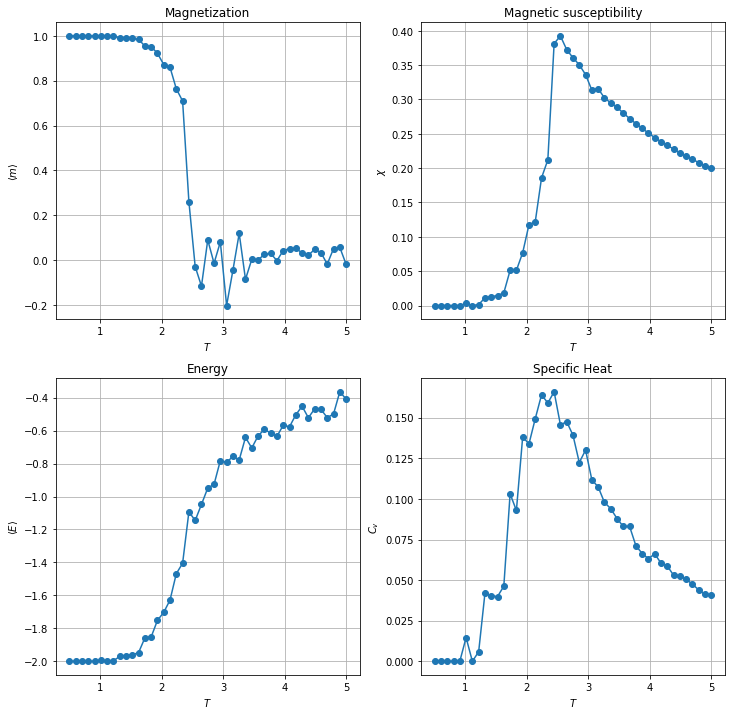

In [17]:
# Plot Magnetization, Magnetic Susceptibility, Energy and Specific Heat

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.title("Magnetization")
plt.grid()
plt.xlabel(r'$T$'); plt.ylabel(r'$\langle m \rangle$')
plt.plot(temperatures,magnetization,'-o')

plt.subplot(222)
plt.title("Magnetic susceptibility")
plt.grid()
plt.xlabel(r'$T$'); plt.ylabel(r'$\chi$')
plt.plot(temperatures,susceptibility,'-o')

plt.subplot(223)
plt.title("Energy")
plt.grid()
plt.xlabel(r'$T$'); plt.ylabel(r'$\langle E \rangle$')
plt.plot(temperatures,energy,'-o')

plt.subplot(224)
plt.title("Specific Heat")
plt.grid()
plt.xlabel(r'$T$'); plt.ylabel(r'$C_v$')
plt.plot(temperatures,specific_heat,'-o')

plt.savefig('Observables.pdf',format='pdf')

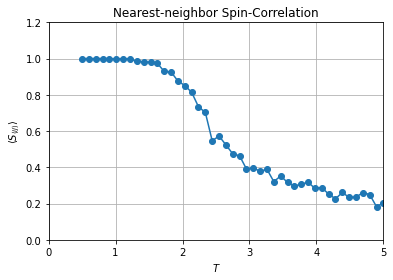

In [16]:
# Plot Nearest-neighbor Spin-Correlation

plt.title("Nearest-neighbor Spin-Correlation")
plt.grid()
plt.xlim(0,5.0); plt.ylim(0,1.2)
plt.xlabel(r'$T$'); plt.ylabel(r'$\langle S_{\langle ij \rangle} \rangle$')
plt.plot(temperatures,spin_corr_nn,'o-')
plt.savefig('SC_nn.pdf',format='pdf')

In [8]:
# Plot Spin-Correlation

# plt.figure()
# plt.title("Spin-Correlation")
# plt.ylabel(r'$ \langle S(0).S(r) \rangle $'); plt.xlabel(r'$r$')
# plt.grid()
# plt.plot(spin_corr[0,:],  label = '%.1f' % temperatures[0])
# plt.plot(spin_corr[10,:], label = '%.1f' % temperatures[10])
# plt.plot(spin_corr[20,:], label = '%.1f' % temperatures[20])
# plt.plot(spin_corr[25,:], label = '%.1f' % temperatures[25])
# plt.plot(spin_corr[29,:],  label = '%.1f' % temperatures[29])
# plt.plot(spin_corr[39,:], label = '%.1f' % temperatures[39])
# plt.legend()

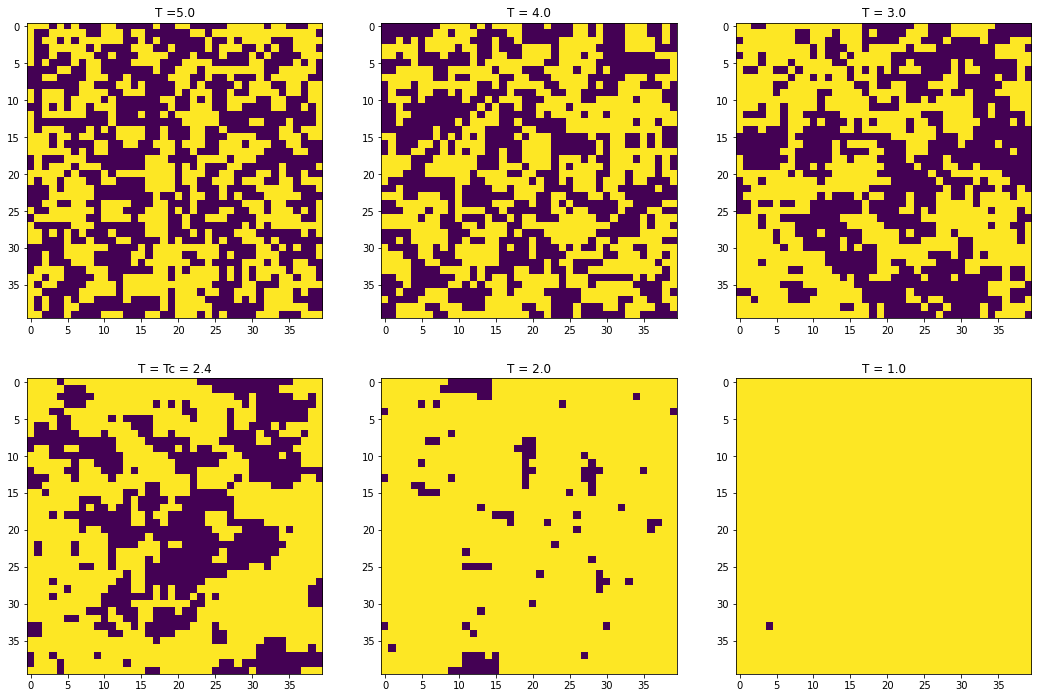

In [18]:
# Plot Lattice Configurations

plt.figure(figsize=(18,12))

plt.subplot(231)
plt.title('T =' + '%.1f' % temperatures[0])
plt.imshow(lattice_save[0,:,:])

plt.subplot(232)
plt.title('T = ' + '%.1f' % temperatures[10])
plt.imshow(lattice_save[10,:,:])

plt.subplot(233)
plt.title('T = ' + '%.1f' % temperatures[20])
plt.imshow(lattice_save[20,:,:])

plt.subplot(234)
plt.title('T = Tc = ' + '%.1f' % temperatures[25])
plt.imshow(lattice_save[25,:,:])

plt.subplot(235)
plt.title('T = ' + '%.1f' % temperatures[29])
plt.imshow(lattice_save[29,:,:])

plt.subplot(236)
plt.title('T = ' + '%.1f' % temperatures[39])
plt.imshow(lattice_save[39,:,:])

plt.savefig('Lattice_config.pdf',format='pdf')